<h1>Imports</h1>

In [54]:
import pandas as pd
import numpy as np

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score, cross_validate
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import random

import matplotlib.pyplot as plt

<h1>Carregando os dados</h1>

In [45]:
#Carregar o dataset
features = pd.read_csv('outReduced2.csv')

In [46]:
features.head(10)

,Bwd Packet Length Min,Subflow Fwd Bytes,Total Length of Fwd Packets,Fwd Packet Length Mean,Bwd Packet Length Std,Flow IAT Min,Fwd IAT Min,Flow IAT Mean,Flow Duration,Flow IAT Std,...,ACK Flag Count,Fwd PSH Flags,SYN Flag Count,Fwd Packets/s,Init_Win_bytes_backward,Bwd Packets/s,Init_Win_bytes_forward,PSH Flag Count,Average Packet Size,Label
0,0,1022,1022,146.000000,439.659284,4,4,3.988552e+05,5185118,1.372181e+06,...,0,0,0,1.350017,252,1.350017,29200,1,238.785714,6
1,0,736,736,73.600000,1639.915430,36,192,3.160859e+05,5057374,1.239255e+06,...,0,0,0,1.977311,243,1.384118,29200,1,624.470588,6
2,0,0,0,0.000000,0.000000,81,0,8.100000e+01,81,0.000000e+00,...,1,0,0,12345.679010,252,12345.679010,270,0,0.000000,6
3,0,969,969,138.428571,463.646417,46,323,4.791930e+05,5271123,1.488840e+06,...,0,0,0,1.327990,244,0.948564,29200,1,199.916667,6
4,0,973,973,139.000000,502.535903,18,18,5.020638e+05,5020638,1.567338e+06,...,0,0,0,1.394245,244,0.796711,29200,1,218.454545,6
5,0,2145,2145,178.750000,1966.095532,59,195,8.573942e+04,1629049,3.339166e+05,...,0,0,0,7.366261,262,4.910841,29200,1,618.150000,6
6,0,358,358,89.500000,381.500000,4,4,7.269101e+05,5088371,1.885618e+06,...,0,0,0,0.786106,235,0.786106,29200,1,140.125000,6
7,0,5927,5927,211.678571,961.566366,40,705,4.653305e+05,21405204,1.188382e+06,...,0,0,0,1.308093,348,0.887635,29200,1,549.319149,6
8,0,0,0,0.000000,0.000000,66,0,6.600000e+01,66,0.000000e+00,...,1,0,0,15151.515150,235,15151.515150,241,0,0.000000,6
9,0,0,0,0.000000,0.000000,91,632,1.350099e+06,4050296,2.337892e+06,...,0,0,0,0.740687,28960,0.246896,29200,1,0.000000,6


In [47]:
#Para identificar todos labels
print(features['Label'].unique())

[6 3 2 7 4 5 1 0]


In [48]:
#Para contar todos labels
features['Label'].value_counts()

Label
0    529918
1    252661
2    158930
3    128027
4      7938
5      5897
6      2180
7      1966
Name: count, dtype: int64

<Axes: ylabel='count'>

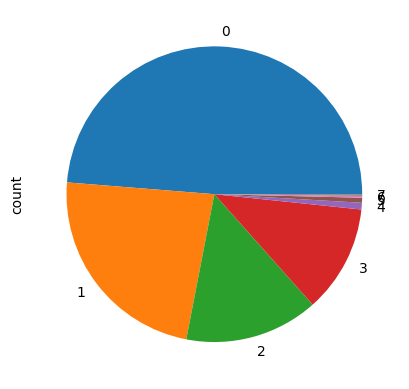

In [25]:
#Para plotar o grafico dos labels
#'pie' - grafico de pizza
#'bar' - grafico em barras
features['Label'].value_counts().plot(kind = 'pie')

In [ ]:
#Agrupando os tipos de ataques
features['Label'] = features['Label'].replace('Web Attack - Brute Force', 'Web Attack')
features['Label'] = features['Label'].replace('Web Attack - XSS', 'Web Attack')
features['Label'] = features['Label'].replace('Web Attack - Sql Injection', 'Web Attack')
features['Label'] = features['Label'].replace('FTP-Patator', 'FTP-Brute')
features['Label'] = features['Label'].replace('SSH-Patator', 'SSH-Brute')
features['Label'] = features['Label'].replace('DoS slowloris', 'DoS')
features['Label'] = features['Label'].replace('DoS Slowhttptest', 'DoS')
features['Label'] = features['Label'].replace('DoS Hulk', 'DoS')
features['Label'] = features['Label'].replace('DoS GoldenEye', 'DoS')
features['Label'] = features['Label'].replace('Bot', 'BotNet')

In [ ]:
#Removendo classes com baixa quantidade de instancias
features.drop(features[features['Label'] == 'Heartbleed'].index, inplace = True)
features.drop(features[features['Label'] == 'Infiltration'].index, inplace = True)

In [ ]:
#Transformação dos labels nominais para valores numéricos
features['Label'] = features['Label'].replace('BENIGN', 0)
features['Label'] = features['Label'].replace('DoS', 1)
features['Label'] = features['Label'].replace('PortScan', 2)
features['Label'] = features['Label'].replace('DDoS', 3)
features['Label'] = features['Label'].replace('FTP-Brute', 4)
features['Label'] = features['Label'].replace('SSH-Brute', 5)
features['Label'] = features['Label'].replace('Web Attack', 6)
features['Label'] = features['Label'].replace('BotNet', 7)

In [49]:
#Seleção de atributos (24 no total com Label)
features = features[['Bwd Packet Length Min','Subflow Fwd Bytes','Total Length of Fwd Packets','Fwd Packet Length Mean','Bwd Packet Length Std','Flow IAT Min','Fwd IAT Min','Flow IAT Mean','Flow Duration','Flow IAT Std','Active Min','Active Mean','Bwd IAT Mean','Fwd IAT Mean','ACK Flag Count','Fwd PSH Flags','SYN Flag Count','Fwd Packets/s','Init_Win_bytes_backward','Bwd Packets/s','Init_Win_bytes_forward','PSH Flag Count','Average Packet Size','Label']]

In [ ]:
#Tratamento de dados infinitos, NaN e Nulos
features[features == np.inf] = np.nan

#Checa se há valores nulos/NaN
features.isnull().values.any()

#Substitua pela valor médio do atributo em questão caso haja valores nulos/NaN
features.fillna(features.mean(), inplace=True)

In [ ]:
#Guarda os labels em um array e exclui a coluna 'Label' do dataframe "features"
labels = np.array(features['Label'])
features = features.drop('Label', axis = 1)

In [20]:
#Realiza o undersampling nas classes
sampling_strategy = {0: 20000, 1: 20000, 2: 20000, 3: 20000, 4: 7938, 5: 5897, 6: 2180, 7:1966}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
features, labels = rus.fit_resample(features, labels)

In [22]:
#Realiza o SMOTE + ENN (oversampling) nas classes
features, labels = SMOTEENN().fit_resample(features, labels)
print(np.unique(labels, return_counts=True))

<h1>Preparando os classificadores</h1>

In [27]:
#Normaliza os dados para o KNN dar certo
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [52]:
#Separa as entradas no treino/teste para a busca do melhor parametro
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, shuffle=True, random_state = 0)

ValueError: Found input variables with inconsistent numbers of samples: [1087517, 155967]

In [28]:
#Checa a quantidade de instancias de cada classe do teste/treino
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

In [29]:
#Realiza a "busca" pelo melhor hiperparametro (estimator) para o Random Forest
param_dist = {'n_estimators': randint(100,400)}
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5)
rand_search.fit(X_train, y_train)

#Variável do melhor classificador
best_rf = rand_search.best_estimator_

#Mostra o melhor hiperparametro
print('Melhor hiperparametro RF:',  best_rf)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([20000, 20000, 20000, 20000,  7938,  5897,  2180,  1966],
       dtype=int64))

In [30]:
#Realiza a "busca" pelo melhor hiperparametro (estimator) para o XGBoost
param_dist = {'n_estimators': randint(100,400)}
xgb = XGBClassifier()
rand_search = RandomizedSearchCV(xgb, param_distributions = param_dist, n_iter=5, cv=5)
rand_search.fit(X_train, y_train)

#Variável do melhor classificador
best_xgb = rand_search.best_estimator_

#Mostra o melhor hiperparametro
print('Melhor hiperparametro XGBoost:',  best_xgb)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([17976, 19398, 19949, 19733, 19860, 19833, 19627, 19591],
      dtype=int64))


In [55]:
#Realiza a "busca" pelo melhor hiperparametro (estimator) para o KNN
param_dist = {'n_neighbors': randint(1,17)}
knn = KNeighborsClassifier()
rand_search = RandomizedSearchCV(knn, param_distributions = param_dist, n_iter=5, cv=5)
rand_search.fit(X_train, y_train)

#Variável do melhor classificador
best_knn = rand_search.best_params_

#Mostra o melhor hiperparametro
print('Melhor hiperparametro KNN:',  best_knn)

NameError: name 'randint' is not defined

In [ ]:
#Criando os classificadores RF, XGBoost e KNN com os melhores parametros
rf = RandomForestClassifier(n_estimators = 300)
xgb = XGBClassifier(n_estimators = 300)
knn = KNeighborsClassifier(n_neighbors = 11)

<h1>Treino e Teste dos modelos</h1>

In [56]:
kFold = KFold(n_splits=5,shuffle=True)
for train_index, test_index in kFold.split(features):
    
    X_train, X_test, y_train, y_test = features[train_index], features[test_index], labels[train_index], labels[test_index]
    
    
    rf.fit(X_train, y_train)
    
    xgb.fit(X_train, y_train)
    
    knn.fit(X_train, y_train)
    
    
    predrf = rf.predict(X_test)
    print("Accuracy RF: ", round(accuracy_score(y_test, predrf), 4), "\n")
    print("Precision RF: ", round(precision_score(y_test, predrf, average='macro'), 4), "\n --- \n")
    
    
    predxgb = xgb.predict(X_test)
    print("Accuracy XGB: ", round(accuracy_score(y_test, predxgb), 4), "\n")
    print("Precision XGB: ", round(precision_score(y_test, predxgb, average='macro'), 4), "\n --- \n")

    
    predknn = knn.predict(X_test)
    print("Accuracy KNN: ", round(accuracy_score(y_test, predknn), 4), "\n")
    print("Precision KNN: ", round(precision_score(y_test, predknn, average='macro'), 4), "\n --- \n")


KeyError: "None of [Index([      0,       1,       2,       3,       4,       5,       6,       8,\n             9,      11,\n       ...\n       1087503, 1087504, 1087506, 1087507, 1087508, 1087509, 1087510, 1087511,\n       1087513, 1087515],\n      dtype='int32', length=870013)] are in the [columns]"

<h1>Construindo e plotando matrizes de confusão dos modelos<h1>
<h2>Utiliza o último resultado do K-Fold</h2>

In [ ]:
#Matriz de confusão do RF
cmrf = confusion_matrix(y_test, predrf)
ConfusionMatrixDisplay(confusion_matrix=cmrf).plot();

In [ ]:
#Matriz de confusão do XGBoost
cmxgb = confusion_matrix(y_test, predxgb)
ConfusionMatrixDisplay(confusion_matrix=cmxgb).plot();

In [ ]:
#Matriz de confusão do KNN
cmknn = confusion_matrix(y_test, predknn)
ConfusionMatrixDisplay(confusion_matrix=cmknn).plot();

In [ ]:
#Se desejado, é possível realizar o cross_validate (CV) (que usa o StratifiedKFold) para re-testar os modelos

#CV do RF
print(cross_validate(rf, features, labels, scoring=['accuracy', 'precision_macro'], cv=5))

#CV do XGBoost
print(cross_validate(xgb, features, labels, scoring=['accuracy', 'precision_macro'], cv=5))

#CV do KNN
print(cross_validate(knn, features, labels, scoring=['accuracy', 'precision_macro'], cv=5))